In [77]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use("seaborn-v0_8")
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools
import os
from tqdm import tqdm
import shap

In [ ]:
model_df = pd.read_csv("data/processed_data/data_for_modeling.csv",
    parse_dates=["Timestamp"]
)
model_df = model_df.set_index("Timestamp")

In [68]:
model_df[model_df.index.year==2025].head()

,hour,day_of_week,month,natural_gas_price_euro_mwh,coal_price_euro_mwh,co2_price_euro_t,ro_gas_capa_available_MW,ro_coal_capa_available_MW,ro_nuclear_capa_available_MW,target_lag_24,target_lag_168,target_lag_1,target,ro_total_load_MW_obs,wind_fc_p50,solar_fc_p50
Timestamp,,,,,,,,,,,,,,,,
2025-01-01 00:00:00+00:00,0,2,1,48.817,15.814286,69.96,2979.4,1133.0,1300.0,93.86,86.44,138.70,134.06,5400.50,225.461,0.0
2025-01-01 01:00:00+00:00,1,2,1,48.817,15.814286,69.96,2979.4,1133.0,1300.0,97.31,85.07,134.06,124.42,5235.50,266.967,0.0
2025-01-01 02:00:00+00:00,2,2,1,48.817,15.814286,69.96,2979.4,1133.0,1300.0,96.50,80.81,124.42,84.48,5144.00,327.800,0.0
2025-01-01 03:00:00+00:00,3,2,1,48.817,15.814286,69.96,2979.4,1133.0,1300.0,96.22,75.99,84.48,64.28,5095.25,378.811,0.0
2025-01-01 04:00:00+00:00,4,2,1,48.817,15.814286,69.96,2979.4,1133.0,1300.0,112.38,80.81,64.28,66.70,5075.75,438.208,0.0


In [69]:
model_df["wind_fc_p50"].dtype

dtype('float64')

Assumption : The 2025 forecasts assume an operational rolling setting: at each hour, all previously observed Day-Ahead prices are available and used as inputs for the model.
In practice, the model would generate forecasts sequentially and incorporate observed prices as soon as they become available, allowing it to correct itself over time.
If lagged prices were not assumed to be available in real time, target-based lag features would have been removed from the 2025 forecast to ensure a fully ex-ante setting.


In [70]:
# ============================================================
# 1) FEATURES / TARGET
# ============================================================

feature_cols = [
    "hour", "day_of_week", "month",
    "natural_gas_price_euro_mwh",
    "coal_price_euro_mwh",
    "co2_price_euro_t",
    "ro_gas_capa_available_MW",
    "ro_coal_capa_available_MW",
    "ro_nuclear_capa_available_MW",
    "ro_total_load_MW_obs",
    "target_lag_24",
    "target_lag_168",
    "target_lag_1",
    "wind_fc_p50",
    "solar_fc_p50"
]

X = model_df[feature_cols].copy()
y = model_df["target"].copy()


print(f"Dataset shape: {X.shape}")
print(f"Date range: {X.index.min()} -> {X.index.max()}")

# ============================================================
# 2) SPLIT TIME-BASED : Train/Val = 2021-2023, Test = 2024
# ============================================================

X_train = X.loc[:"2023-12-31"]
y_train = y.loc[:"2023-12-31"]

X_test = X.loc["2024-01-01":"2024-12-31"]
y_test = y.loc["2024-01-01":"2024-12-31"]

print(f"\nTrain: {len(X_train)} obs ({X_train.index.min()} -> {X_train.index.max()})")
print(f"Test : {len(X_test)} obs ({X_test.index.min()} -> {X_test.index.max()})")

# ============================================================
# 3) TRAIN FINAL MODEL 
# ============================================================

best_params = {
    "n_estimators": 500,
    "learning_rate": 0.01,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.9
}

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    **best_params
)

model.fit(X_train, y_train, verbose=0)

# ============================================================
# 4) BACKTEST 2024
# ============================================================

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nBacktest 2024 -> MAE: {mae:.2f} €/MWh | RMSE: {rmse:.2f} €/MWh")

# Monthly MAE breakdown
test_results = pd.DataFrame({"actual": y_test, "predicted": y_pred}, index=y_test.index)
test_results["abs_error"] = (test_results["actual"] - test_results["predicted"]).abs()
monthly_mae = test_results["abs_error"].resample("MS").mean()

print("\nMonthly MAE breakdown (2024):")
for month, v in monthly_mae.items():
    print(f"  {month.strftime('%b %Y')}: {v:.2f} €/MWh")


# ============================================================
# 5) FORECAST 2025 (direct / one-shot)
#    Retrain on all available data up to end of 2024
# ============================================================

X_full = X.loc[:"2024-12-31"]
y_full = y.loc[:"2024-12-31"]

model.fit(X_full, y_full, verbose=0)

X_2025 = X.loc["2025-01-01":"2025-12-31"]
y_2025_pred = model.predict(X_2025)

print(f"\n2025 forecast generated for {len(y_2025_pred)} hours")
print(f"Mean: {np.mean(y_2025_pred):.2f} €/MWh | Min: {np.min(y_2025_pred):.2f} | Max: {np.max(y_2025_pred):.2f}")

forecast_2025 = pd.DataFrame({
    "timestamp": X_2025.index,
    "predicted_price_eur_mwh": y_2025_pred
})
forecast_2025.to_csv("data/romania_da_price_forecast_2025.csv", index=False)
print("Saved: romania_da_price_forecast_2025.csv")

Dataset shape: (43656, 15)
Date range: 2021-01-08 00:00:00+00:00 -> 2025-12-31 23:00:00+00:00

Train: 26112 obs (2021-01-08 00:00:00+00:00 -> 2023-12-31 23:00:00+00:00)
Test : 8784 obs (2024-01-01 00:00:00+00:00 -> 2024-12-31 23:00:00+00:00)

Backtest 2024 -> MAE: 15.15 €/MWh | RMSE: 34.79 €/MWh

Monthly MAE breakdown (2024):
  Jan 2024: 6.21 €/MWh
  Feb 2024: 5.95 €/MWh
  Mar 2024: 6.48 €/MWh
  Apr 2024: 10.21 €/MWh
  May 2024: 9.67 €/MWh
  Jun 2024: 14.22 €/MWh
  Jul 2024: 28.70 €/MWh
  Aug 2024: 19.69 €/MWh
  Sep 2024: 23.81 €/MWh
  Oct 2024: 13.99 €/MWh
  Nov 2024: 27.01 €/MWh
  Dec 2024: 15.80 €/MWh

2025 forecast generated for 8760 hours
Mean: 107.88 €/MWh | Min: -5.40 | Max: 463.78
Saved: romania_da_price_forecast_2025.csv


In [71]:
# ============================================================
# HISTORICAL NEGATIVE PRICES ANALYSIS (2021-2024 ONLY)
# ============================================================

# It can explain why the model predicted negative prices in 2025

# Filter on 2021-2024
historical_data = model_df.loc[:"2024-12-31"].copy()
price_col = 'target' 

print("="*60)
print("HISTORICAL NEGATIVE PRICES ANALYSIS (2021-2024)")
print("="*60)

# Overall stats
total_obs = len(historical_data)
negative_obs = (historical_data[price_col] < 0).sum()
zero_obs = (historical_data[price_col] == 0).sum()

print(f"\nOVERVIEW 2021-2024")
print(f"Total observations: {total_obs:,}")
print(f"Negative prices: {negative_obs} ({100*negative_obs/total_obs:.2f}%)")
print(f"Zero prices: {zero_obs} ({100*zero_obs/total_obs:.2f}%)")
print(f"Min price: {historical_data[price_col].min():.2f} €/MWh")
print(f"Max price: {historical_data[price_col].max():.2f} €/MWh")

# Analysis by year
print("\nBREAKDOWN BY YEAR")
print(f"{'Year':6s} | {'Total obs':>10s} | {'Negative':>9s} | {'%':>6s} | {'Min price':>10s}")
print("-" * 60)

for year in [2021, 2022, 2023, 2024]:
    year_data = historical_data.loc[f"{year}-01-01":f"{year}-12-31", price_col]
    if len(year_data) > 0:
        neg_count = (year_data < 0).sum()
        neg_pct = 100 * neg_count / len(year_data)
        min_price = year_data.min()
        print(f"{year:6d} | {len(year_data):10,} | {neg_count:9d} | {neg_pct:5.2f}% | {min_price:9.2f}€")

# Extract negative observations
negative_prices = historical_data[historical_data[price_col] < 0].copy()

if len(negative_prices) > 0:
    print(f"\DETAILED ANALYSIS OF {len(negative_prices)} NEGATIVE PRICES")
    
    # Distribution by hour
    negative_prices['hour'] = negative_prices.index.hour
    negative_prices['day_of_week'] = negative_prices.index.dayofweek
    negative_prices['month'] = negative_prices.index.month
    
    print("\n--- Distribution by hour ---")
    hourly_neg = negative_prices['hour'].value_counts().sort_index()
    for hour, count in hourly_neg.items():
        pct = 100 * count / len(negative_prices)
        print(f"Hour {hour:02d}h: {count:4d} ({pct:5.1f}%)")
    
    print("\n--- Distribution by month ---")
    monthly_neg = negative_prices['month'].value_counts().sort_index()
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    for month, count in monthly_neg.items():
        pct = 100 * count / len(negative_prices)
        print(f"{month_names[month]}: {count:4d} ({pct:5.1f}%)")
    
    print("\n--- Distribution by day of week ---")
    dow_neg = negative_prices['day_of_week'].value_counts().sort_index()
    dow_names = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    for dow, count in dow_neg.items():
        pct = 100 * count / len(negative_prices)
        print(f"{dow_names[dow]}: {count:4d} ({pct:5.1f}%)")
    

HISTORICAL NEGATIVE PRICES ANALYSIS (2021-2024)

OVERVIEW 2021-2024
Total observations: 34,896
Negative prices: 117 (0.34%)
Zero prices: 147 (0.42%)
Min price: -106.36 €/MWh
Max price: 1021.61 €/MWh

BREAKDOWN BY YEAR
Year   |  Total obs |  Negative |      % |  Min price
------------------------------------------------------------
  2021 |      8,592 |         0 |  0.00% |      0.02€
  2022 |      8,760 |         0 |  0.00% |      0.17€
  2023 |      8,760 |        32 |  0.37% |    -23.18€
  2024 |      8,784 |        85 |  0.97% |   -106.36€
\DETAILED ANALYSIS OF 117 NEGATIVE PRICES

--- Distribution by hour ---
Hour 00h:    1 (  0.9%)
Hour 01h:    1 (  0.9%)
Hour 02h:    2 (  1.7%)
Hour 03h:    2 (  1.7%)
Hour 06h:    1 (  0.9%)
Hour 07h:    3 (  2.6%)
Hour 08h:    8 (  6.8%)
Hour 09h:   13 ( 11.1%)
Hour 10h:   18 ( 15.4%)
Hour 11h:   28 ( 23.9%)
Hour 12h:   24 ( 20.5%)
Hour 13h:   10 (  8.5%)
Hour 14h:    4 (  3.4%)
Hour 15h:    1 (  0.9%)
Hour 23h:    1 (  0.9%)

--- Distribution b

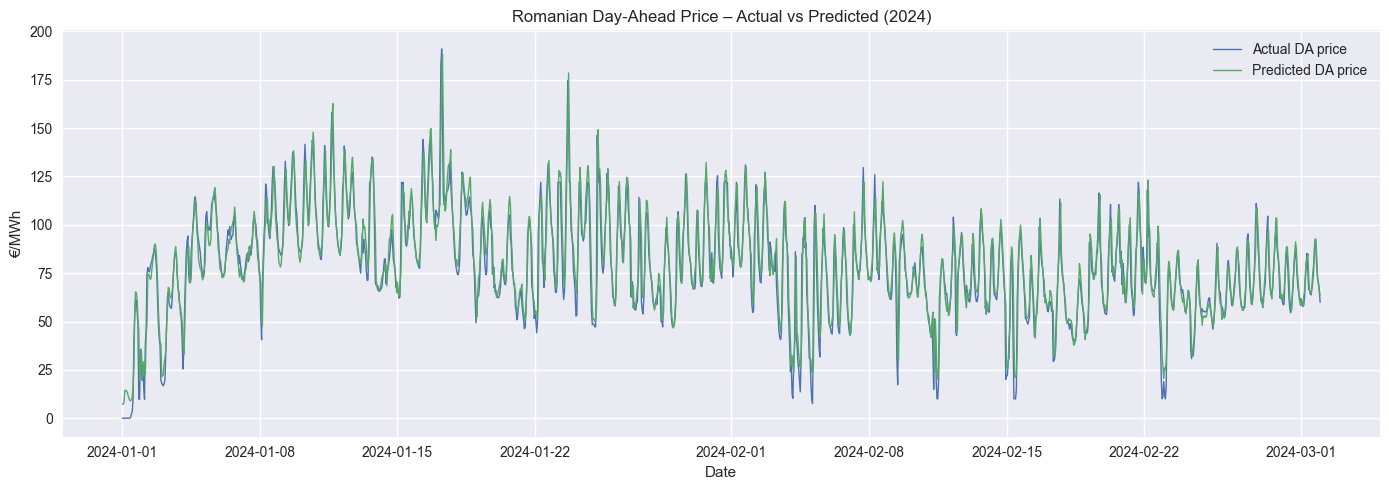

In [78]:
# ============================================================
# PLOT: REAL VS PREDICTED PRICES (2024) : BACKTEST
# ============================================================

plt.figure(figsize=(14, 5))

# PLOT: For readability, we can display only 2 months
plot_start = "2024-01-01"
plot_end = "2024-03-01"

plt.plot(
    y_test.loc[plot_start:plot_end],
    label="Actual DA price",
    linewidth=1
)

plt.plot(
    pd.Series(y_pred, index=y_test.index).loc[plot_start:plot_end],
    label="Predicted DA price",
    linewidth=1
)

plt.title("Romanian Day-Ahead Price – Actual vs Predicted (2024)")
plt.ylabel("€/MWh")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


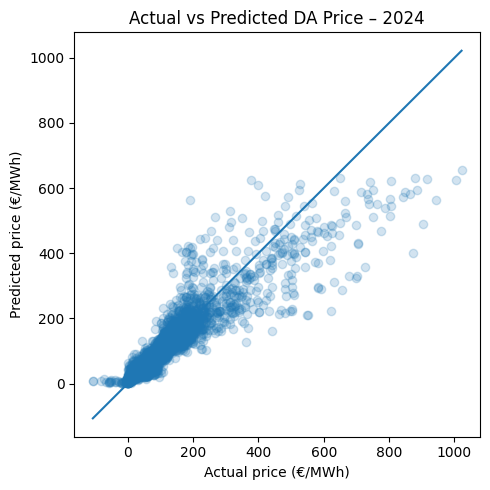

In [73]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)
plt.xlabel("Actual price (€/MWh)")
plt.ylabel("Predicted price (€/MWh)")
plt.title("Actual vs Predicted DA Price – 2024")
plt.tight_layout()
plt.show()


### Comparison 2025: forecast vs actuals in ordrer to compute ex-post metrics


Jan 2025 (hourly) | N=744 | MAE=13.05 €/MWh | RMSE=23.94 €/MWh


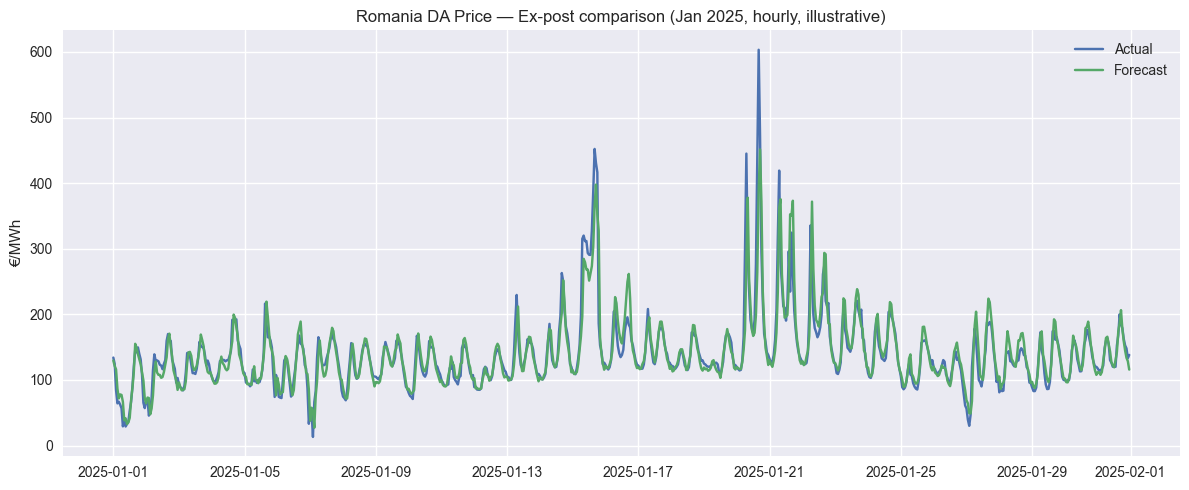

Jul 2025 (hourly) | N=744 | MAE=10.09 €/MWh | RMSE=18.42 €/MWh


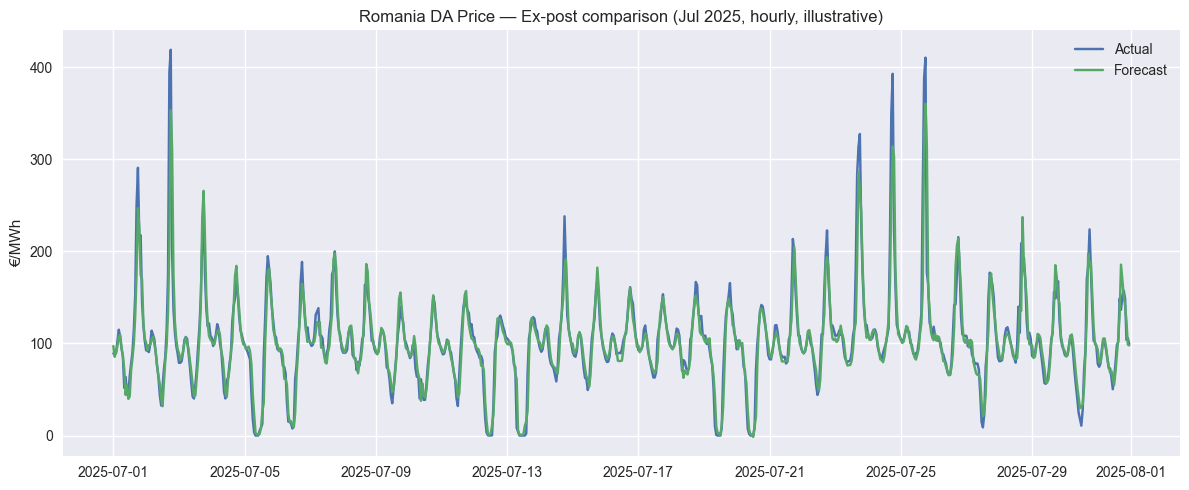

In [ ]:

fcst = pd.read_csv(
    "data/romania_da_price_forecast_2025.csv",
    parse_dates=["timestamp"]
).set_index("timestamp")

fcst = fcst.rename(columns={"predicted_price_eur_mwh": "Forecast"})
fcst.index = fcst.index.tz_convert("UTC") if fcst.index.tz is not None else fcst.index.tz_localize("UTC")

# -----------------------
# Load actuals from model_df
# -----------------------
act = model_df[["target"]].rename(columns={"target": "Actual"}).copy()
act.index = act.index.tz_convert("UTC") if act.index.tz is not None else act.index.tz_localize("UTC")

# -----------------------
# Filter 2025 + robust hourly alignment
# -----------------------
act_2025 = act.loc["2025-01-01":"2025-12-31"].copy()
fcst_2025 = fcst.loc["2025-01-01":"2025-12-31"].copy()

act_2025.index = act_2025.index.floor("h")
fcst_2025.index = fcst_2025.index.floor("h")

cmp_h = act_2025.join(fcst_2025[["Forecast"]], how="inner").dropna()

if cmp_h.empty:
    raise ValueError("Hourly merge is empty. Check that model_df contains 2025 hourly target data.")
# -----------------------
# Functions for monthly slicing, metrics, and plotting
# -----------------------
def month_slice(cmp, year, month):
    start = pd.Timestamp(year=year, month=month, day=1, tz="UTC")
    end = start + pd.offsets.MonthBegin(1)
    return cmp.loc[start:end - pd.Timedelta(seconds=1)].copy()

def mae_rmse(sub):
    err = sub["Forecast"] - sub["Actual"]
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    return mae, rmse

def plot_month(sub, year, month):
    label = pd.Timestamp(year=year, month=month, day=1).strftime("%b %Y")
    plt.figure(figsize=(12, 5))
    plt.plot(sub.index, sub["Actual"], label="Actual")
    plt.plot(sub.index, sub["Forecast"], label="Forecast")
    plt.title(f"Romania DA Price — Ex-post comparison ({label}, hourly, illustrative)")
    plt.ylabel("€/MWh")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------
# January metrics + plot
# -----------------------
jan = month_slice(cmp_h, 2025, 1)
mae_jan, rmse_jan = mae_rmse(jan)
print(f"Jan 2025 (hourly) | N={len(jan)} | MAE={mae_jan:.2f} €/MWh | RMSE={rmse_jan:.2f} €/MWh")
plot_month(jan, 2025, 1)

# -----------------------
# July metrics + plot
# -----------------------
jul = month_slice(cmp_h, 2025, 7)
mae_jul, rmse_jul = mae_rmse(jul)
print(f"Jul 2025 (hourly) | N={len(jul)} | MAE={mae_jul:.2f} €/MWh | RMSE={rmse_jul:.2f} €/MWh")
plot_month(jul, 2025, 7)


In [75]:
err_all = cmp_h["Forecast"] - cmp_h["Actual"]
mae_all = float(np.mean(np.abs(err_all)))
rmse_all = float(np.sqrt(np.mean(err_all**2)))

print(f"All 2025 (hourly) | N={len(cmp_h)} | MAE={mae_all:.2f} €/MWh | RMSE={rmse_all:.2f} €/MWh")


All 2025 (hourly) | N=8760 | MAE=12.50 €/MWh | RMSE=21.07 €/MWh


 97%|=================== | 1449/1500 [00:26<00:00]       

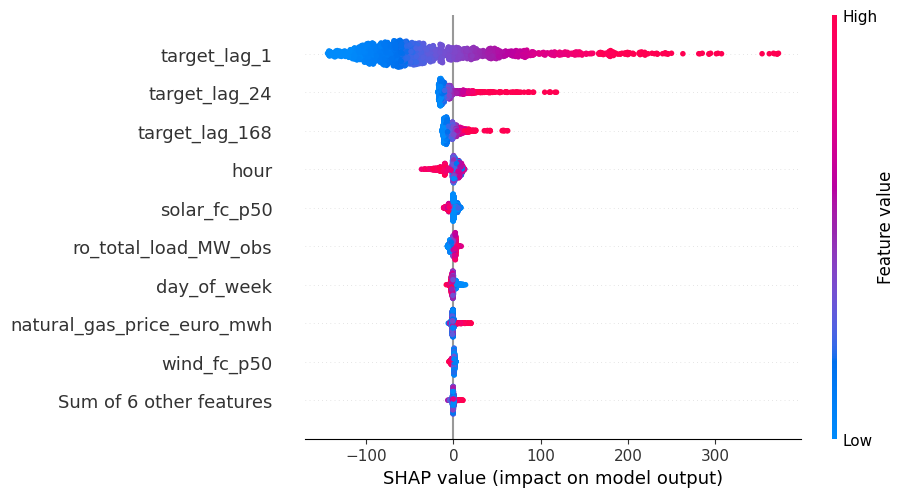

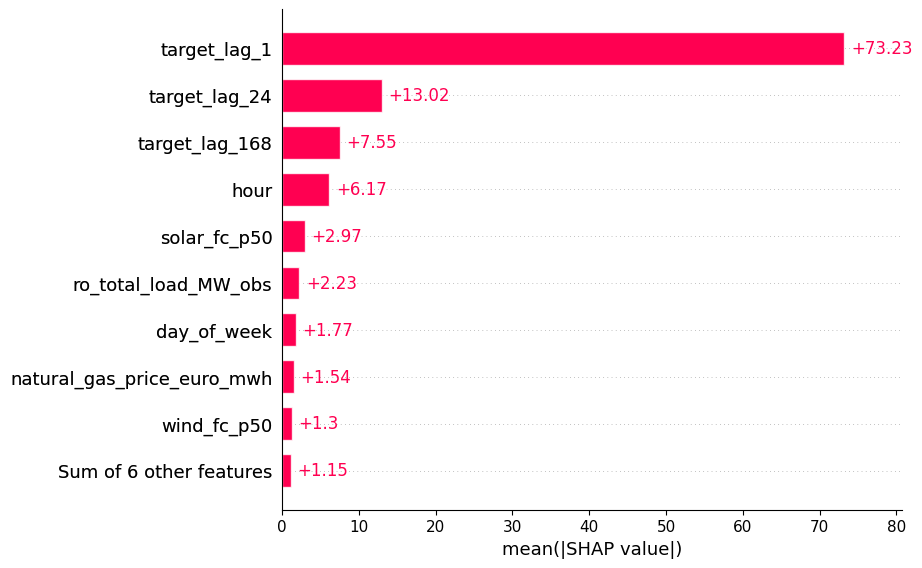

In [ ]:
# Explicability of the results with SHAP

if not isinstance(X_train, pd.DataFrame):
    X_train_df = pd.DataFrame(X_train)
else:
    X_train_df = X_train.copy()

# Sample background data for SHAP
X_bg = X_train_df.sample(min(1500, len(X_train_df)), random_state=42)

explainer = shap.Explainer(model, X_bg)
shap_values = explainer(X_bg)

# 1) Summary plot (impact + sign)
shap.plots.beeswarm(shap_values, max_display=10)

# 2) Bar plot (global importance)
shap.plots.bar(shap_values, max_display=10)


Positive SHAP values contribute to increasing the predicted value of the target variable, while negative values reduce it relative to the model's reference value.

The y-axis: lists the most important features at the top, by average importance (absolute SHAP value) across the dataset.